**<span style="color: #3D74AB;">In The Name of God</span>**

---

# **<span style="color: #3D74AB;">Assignment 2</span>**

- **Parsa Bukani - 810102501**
- **Mani Hosseini - 810102552**
- **Erfan Falahati - 810102491**

In [221]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

# <span style="color: coral;">Data Ingestion Layer</span>

## <span style="color: white;">Kafka Consumer Implementation</span>

**[Kafka Producer](producer.py)**

**[Kafka Consumer](consumer.py)**


## <span style="color: white;">Schema Management</span>
**<span style="color: #99CCFF;">The transaction data is stored in JSON by [Kafka Consumer](consumer.py) for subsequent insertion into MongoDB collections.</span>**

# <span style="color: coral;">Batch Processing Layer</span>

## <span style="color: white;">Commission Analysis Batch Job</span>


In [222]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("darooghe").getOrCreate()

df = spark.read.json('content/validated_transactions.json')
df.show()

+-------+-----------------+---------------+-----------+-------------+--------------------+---------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
| amount|commission_amount|commission_type|customer_id|customer_type|         device_info| failure_reason|               lat|               lng|merchant_category|merchant_id|payment_method|risk_level|  status|           timestamp|total_amount|      transaction_id|vat_amount|
+-------+-----------------+---------------+-----------+-------------+--------------------+---------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
| 803339|            16066|         tiered|   cust_153|     business|{2.4.1, Samsung G...|           None|35.759416269976306|  51.3495523178515|           retail|   merch_3

### <span style="color: #99CCFF;">Part I</span>


In [223]:
from pyspark.sql.functions import sum, avg, count, col, when


filtered_df = df.filter(df["status"] == "approved")

commission_analysis_df = filtered_df.select(
    "transaction_id",
    "commission_type",
    "merchant_category",
    "commission_amount",
    "total_amount",
    "amount"
)


commission_analysis_df = commission_analysis_df.groupBy("merchant_category").agg(
    sum("commission_amount").alias("total_commission"),
    avg("commission_amount").alias("avg_commission"),
    count("*").alias("transaction_count"),
    sum("amount").alias("total_transaction_amount"),
    count(when(col("commission_type") == "flat", 1)).alias("flat_count"),
    count(when(col("commission_type") == "progressive", 1)).alias("progressive_count"),
    count(when(col("commission_type") == "tiered", 1)).alias("tiered_count"),
)

commission_analysis_df = commission_analysis_df.withColumn(
    "commission_to_transaction_ratio", 
    col("total_commission") / col("total_transaction_amount")
)
commission_analysis_df.show()

+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|merchant_category|total_commission|    avg_commission|transaction_count|total_transaction_amount|flat_count|progressive_count|tiered_count|commission_to_transaction_ratio|
+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|           retail|        54708958| 20582.75319789315|             2658|              2735512495|       902|              884|         872|           0.019999527730177668|
|    entertainment|        55207764| 20576.87812150578|             2683|              2760455235|       918|              887|         878|           0.019999514319238725|
|     food_service|        56491582|20587.311224489797|             2744|              2824646382|       916|              948|        

### <span style="color: #99CCFF;">Part II</span>

- Commission-to-Transaction Ratio: The commission-to-transaction ratio is relatively consistent across all categories, with values ranging between 0.0199995 and 0.0200. This suggests that the commission percentage, in relation to the transaction amount, does not vary significantly across these merchant categories

- Average Commission: The average commission amount, however, shows more significant differences between the categories

Thus, merchants in the **food_service** and **retail** sectors are performing best in terms of overall commission earned, though the commission-to-transaction ratio is fairly consistent across all categories

In [224]:
data = [(row["merchant_category"], row["commission_to_transaction_ratio"], row["avg_commission"]) for row in commission_analysis_df.select(
    "merchant_category", 
    "commission_to_transaction_ratio", 
    "avg_commission"
).collect()]

sorted_data = sorted(data, key=lambda x: x[2], reverse=True)

for category, ratio, avg in sorted_data:
    print(f"Category: {category}, Commission-to-Transaction Ratio: {ratio}, Average Commission: {avg}")


Category: government, Commission-to-Transaction Ratio: 0.019999540465755198, Average Commission: 20981.48911037283
Category: food_service, Commission-to-Transaction Ratio: 0.019999523607624452, Average Commission: 20587.311224489797
Category: retail, Commission-to-Transaction Ratio: 0.019999527730177668, Average Commission: 20582.75319789315
Category: entertainment, Commission-to-Transaction Ratio: 0.019999514319238725, Average Commission: 20576.87812150578
Category: transportation, Commission-to-Transaction Ratio: 0.019999522239329513, Average Commission: 20319.587278641127


## <span style="color: white;">Transaction Pattern Analysis </span>


### <span style="color: #99CCFF;">Part I</span>

In [225]:
from pyspark.sql.functions import hour, count, minute

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))

temporal_pattern_df = filtered_df.groupBy("hour").agg(
    count("*").alias("transaction_count")
)

temporal_pattern_df.sort(col("transaction_count").desc()).show()


+----+-----------------+
|hour|transaction_count|
+----+-----------------+
|  22|              603|
|  10|              597|
|  11|              595|
|  23|              588|
|  20|              587|
|   1|              581|
|  15|              576|
|   7|              576|
|  14|              576|
|  19|              574|
|   5|              573|
|  21|              569|
|  13|              564|
|   9|              564|
|   8|              562|
|  12|              558|
|   6|              555|
|   0|              553|
|  18|              552|
|  16|              550|
+----+-----------------+
only showing top 20 rows



### <span style="color: #99CCFF;">Part II</span>

In [226]:
peak_time_df = temporal_pattern_df.orderBy(col("transaction_count").desc())
peak_time_df.show(5)

+----+-----------------+
|hour|transaction_count|
+----+-----------------+
|  22|              603|
|  10|              597|
|  11|              595|
|  23|              588|
|  20|              587|
+----+-----------------+
only showing top 5 rows



### <span style="color: #99CCFF;">Part III</span>

In [227]:
customer_segment_df = filtered_df.groupBy("customer_id").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_spent")
)
customer_segment_df.sort(col("total_spent").desc()).show()

+-----------+-----------------+-----------+
|customer_id|transaction_count|total_spent|
+-----------+-----------------+-----------+
|   cust_365|               25|   30502396|
|   cust_804|               26|   30028503|
|   cust_611|               24|   28581005|
|    cust_34|               23|   27915964|
|   cust_717|               22|   27191478|
|   cust_212|               23|   26651197|
|   cust_444|               21|   25884450|
|   cust_653|               23|   25840206|
|   cust_104|               23|   25090163|
|   cust_156|               21|   25037024|
|   cust_873|               20|   24774426|
|   cust_795|               20|   24682282|
|   cust_408|               23|   24356672|
|   cust_497|               22|   24111243|
|   cust_922|               20|   24028112|
|   cust_182|               20|   23856343|
|   cust_609|               21|   23799405|
|    cust_78|               18|   23500724|
|   cust_671|               21|   23295865|
|   cust_163|               22| 

### <span style="color: #99CCFF;">Part IV</span>

In [228]:
merchant_behavior_df = filtered_df.groupBy("merchant_category").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_sales")
)

merchant_behavior_df.sort(col("transaction_count").desc()).show()

+-----------------+-----------------+-----------+
|merchant_category|transaction_count|total_sales|
+-----------------+-----------------+-----------+
|   transportation|             2767| 2811282056|
|     food_service|             2744| 2824646382|
|       government|             2709| 2842008000|
|    entertainment|             2683| 2760455235|
|           retail|             2658| 2735512495|
+-----------------+-----------------+-----------+



### <span style="color: #99CCFF;">Part V</span>

In [229]:
from pyspark.sql.functions import when

filtered_df = filtered_df.withColumn(
    "time_of_day",
    when((col("hour") >= 6) & (col("hour") < 12), "Morning")
    .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
    .when((col("hour") >= 18) & (col("hour") < 24), "Evening")
    .otherwise("Night")
)

time_of_day_df = filtered_df.groupBy("time_of_day").agg(
    count("*").alias("transaction_count")
)

time_of_day_df.sort(col("transaction_count").desc()).show()



+-----------+-----------------+
|time_of_day|transaction_count|
+-----------+-----------------+
|    Evening|             3473|
|    Morning|             3449|
|  Afternoon|             3354|
|      Night|             3285|
+-----------+-----------------+



### <span style="color: #99CCFF;">Part VI</span>

In [230]:

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))
filtered_df = filtered_df.withColumn("minute", minute(col("timestamp")))

spending_trend_df = filtered_df.groupBy("hour", "minute").agg(
    sum("amount").alias("total_spent")
).orderBy("hour", "minute")

spending_trend_df.sort(col("total_spent").desc()).show()


+----+------+-----------+
|hour|minute|total_spent|
+----+------+-----------+
|   1|    10|   24677809|
|   1|    18|   23657679|
|  18|    32|   23479257|
|  14|    31|   23009809|
|  11|     8|   21868599|
|  14|     4|   21460093|
|   9|     8|   21403855|
|  22|    31|   21194775|
|   1|    38|   21104720|
|  19|    37|   21006314|
|  19|    56|   20686743|
|   2|     4|   20619752|
|  11|    22|   20431260|
|   1|    57|   19940601|
|  23|    24|   19523251|
|   1|    58|   19098596|
|   8|    43|   19085559|
|  20|    55|   19065747|
|   5|    18|   19028823|
|  18|    38|   18812791|
+----+------+-----------+
only showing top 20 rows



## <span style="color: white;">Data Storage Implementation</span>


### <span style="color: #99CCFF;">Part I</span>

In [231]:
from pymongo import MongoClient
from datetime import datetime

client = MongoClient("mongodb://localhost:27017/")
db = client['daroogheDB']
db.drop_collection('transactions')
transactions_collection = db['transactions']


rows = df.filter(df["status"] == "approved").collect()


documents = []
for row in rows:
    transaction = {
        "id": row['transaction_id'],
        "timestamp": datetime.fromisoformat(row['timestamp']),
        "customer_id": row['customer_id'],
        "merchant_id": row['merchant_id'],
        "lat": row['lat'],
        "long": row['lng'],
        "merchant_category": row['merchant_category'],
        "amount": row['amount'],
        "vat_amount": row['vat_amount'],
        "commission_type": row["commission_type"],
        "commission_amount": row["commission_amount"],
        "total_amount": row["total_amount"],
        "customer_type": row["customer_type"],
        "risk_level": row["risk_level"],
        "failure_reason": row["failure_reason"],
        "device_info": row["device_info"],
        "payment_method": row["payment_method"],
        "createdAt": datetime.utcnow(),
    }
    documents.append(transaction)

if documents:
    transactions_collection.insert_many(documents)


/tmp/ipykernel_24034/3393568113.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "createdAt": datetime.utcnow(),


### <span style="color: #99CCFF;">Part II</span>

#### <font color="#3D74AB">Create a TTL Index in MongoDB</font>

In [232]:
transactions_collection.create_index([("timestamp", 1)], expireAfterSeconds=86400)
print(transactions_collection.index_information())

{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'timestamp_1': {'v': 2, 'key': [('timestamp', 1)], 'expireAfterSeconds': 86400}}


### <span style="color: #99CCFF;">Part III</span>

#### <font color="#20B2AA">Group by Merchant</font>

In [233]:
pipeline = [
    {
        "$group": {
            "_id": "$merchant_category",
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    { 
        "$sort": { "total_sales": -1 }
    }
]

result = transactions_collection.aggregate(pipeline)

print("merchant_category\ttotal_sales\t\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )

merchant_category	total_sales		transaction_count
government              2842008000              2709      
food_service            2824646382              2744      
transportation          2811282056              2767      
entertainment           2760455235              2683      
retail                  2735512495              2658      


#### <font color="#20B2AA">Group by Customer Segment</font>

In [234]:
pipeline = [
    {
        "$group": {
            "_id": "$customer_type",
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    {
        "$sort": { "total_sales": -1 } 
    }
]

result = transactions_collection.aggregate(pipeline)

print("customer_type\t\ttotal_sales\t\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )

customer_type		total_sales		transaction_count
CIfunctionP             4770310710              4628      
individual              4657497634              4494      
business                4546095824              4439      


### <font color="#3D74AB">Summarized transaction data</font>

In [235]:
pipeline = [
    {
        "$project": {
            "hour": { 
                "$dateToString": { 
                    "format": " %H:00", 
                    "date": "$timestamp",
                }
            },
            "amount": 1
        }
    },
    {
        "$group": {
            "_id": "$hour", 
            "total_sales": { "$sum": "$amount" },
            "transaction_count": { "$count": {} }
        }
    },
    {
        "$sort": { "_id": 1 }  
    }
]

result = transactions_collection.aggregate(pipeline)

print("hour\t\t\ttotal_sales\ttransaction_count")
for record in result:
    print(
        f"{record['_id'].ljust(24)}"
        f"{str(record['total_sales']).ljust(24)}"
        f"{str(record['transaction_count']).ljust(10)}"
    )


hour			total_sales	transaction_count
 00:00                  557112922               537       
 01:00                  520974421               544       
 02:00                  577821925               559       
 03:00                  576598602               540       
 04:00                  623966101               608       
 05:00                  562926574               546       
 06:00                  628583337               581       
 07:00                  633633896               610       
 08:00                  578503799               552       
 09:00                  578853036               569       
 10:00                  584337648               574       
 11:00                  582516560               592       
 12:00                  542816751               561       
 13:00                  565633510               523       
 14:00                  567236867               541       
 15:00                  561524680               551       
 16:00             

### <font color="#3D74AB">Commission Reports</font>

In [236]:
pipeline = [
    {
        "$project": {
            "hour": { 
                "$dateToString": { 
                    "format": "%H:00",
                    "date": "$timestamp",
                }
            },
            "merchant_category": 1,
            "commission_amount": 1
        }
    },
    {
        "$group": {
            "_id": { 
                "merchant_category": "$merchant_category", 
                "hour": "$hour" 
            },
            "total_commission": { "$sum": "$commission_amount" }
        }
    },
    {
        "$sort": { "_id.hour": 1 } 
    }
]

result = transactions_collection.aggregate(pipeline)

print("hour\t\t\tmerchant_category\ttotal_commission")
for record in result:
    print(
        f"{record['_id']['hour'].ljust(24)}"
        f"{record['_id']['merchant_category'].ljust(24)}"
        f"{str(round(record['total_commission'], 2)).ljust(10)}"
    )



hour			merchant_category	total_commission
00:00                   retail                  2380114   
00:00                   government              2494498   
00:00                   food_service            2047585   
00:00                   transportation          2204571   
00:00                   entertainment           2015226   
01:00                   transportation          2226940   
01:00                   food_service            2276216   
01:00                   government              1949155   
01:00                   retail                  2046160   
01:00                   entertainment           1920739   
02:00                   food_service            2330373   
02:00                   government              2376548   
02:00                   transportation          2622992   
02:00                   retail                  1620945   
02:00                   entertainment           2605322   
03:00                   government              2604331   
03:00         

# <span style="color: coral;">Visualization</span>

In [237]:
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client['daroogheDB']
transactions_collection = db['transactions']

transactions = list(transactions_collection.find())
df = pd.DataFrame(transactions)


## <span style="color: #99CCFF;">Part I</span>
#### <span style="color: #3D74AB;">Transaction Volume Over Time</span>

**The peak traffic for transactions occurs around 4:00 AM, 7:00 AM, 11:00 AM , 16:00 PM, 18:00 PM and 19:00 PM**


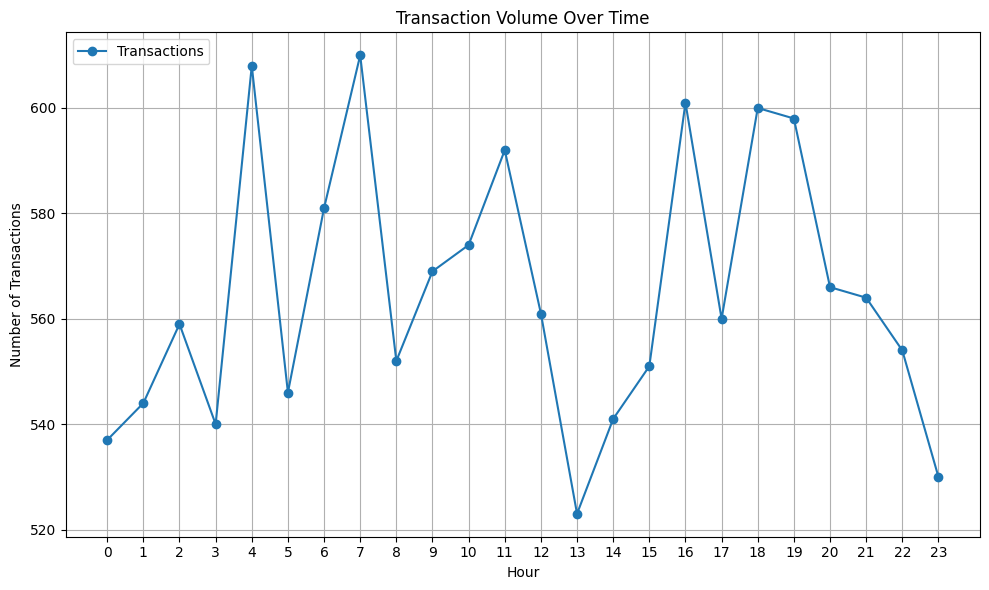

In [238]:
import matplotlib.pyplot as plt

volume_per_day = df.groupby(df['timestamp'].dt.hour).size()


plt.figure(figsize=(10, 6))
volume_per_day.plot(kind='line', label='Transactions', marker='o')
plt.title('Transaction Volume Over Time')
plt.xlabel('Hour')
plt.xticks(range(0, 24))
plt.ylabel('Number of Transactions')
plt.legend(loc='upper left') 
plt.grid(True)
plt.tight_layout()
plt.show()


## <span style="color: #99CCFF;">Part II</span>
### <span style="color: #3D74AB;">Merchant Analysis</span>

**According to the chart, the highest number of transactions performed by a user is around 300 transactions.**

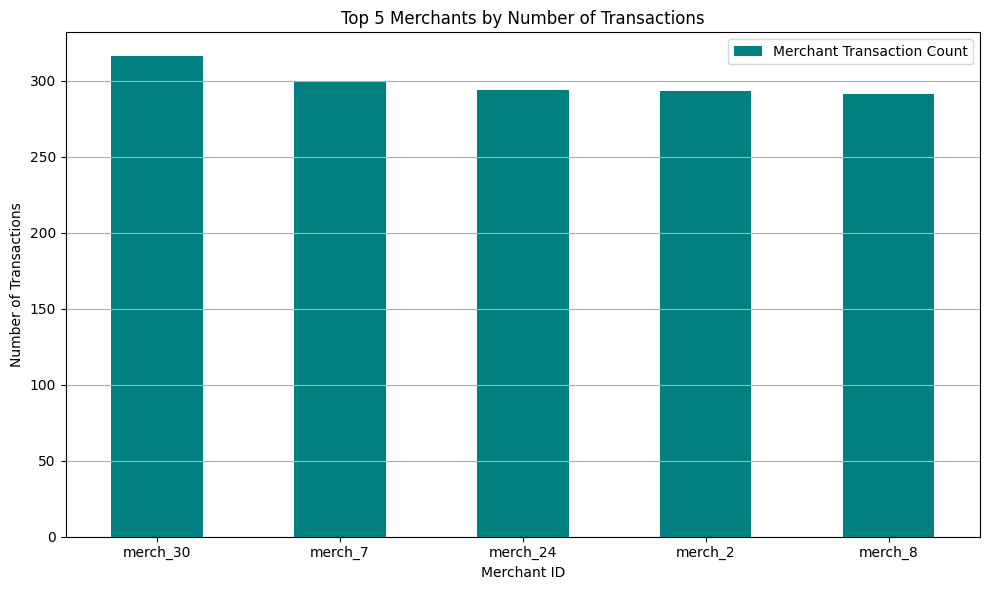

In [239]:
top_merchants = df['merchant_id'].value_counts().head(5)

plt.figure(figsize=(10, 6))
top_merchants.plot(kind='bar', color='teal', label='Merchant Transaction Count')
plt.title('Top 5 Merchants by Number of Transactions')
plt.xlabel('Merchant ID')
plt.ylabel('Number of Transactions')
plt.legend(loc='upper right') 
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## <span style="color: #99CCFF;">Part III</span>
### <span style="color: #3D74AB;">User Activity</span>

**We observe that the number of users who perform a specific number of transactions follows a normal distribution with a mean of 13.56 and a variance of 13.08.**


mean: 13.561
variance: 13.085364364364363


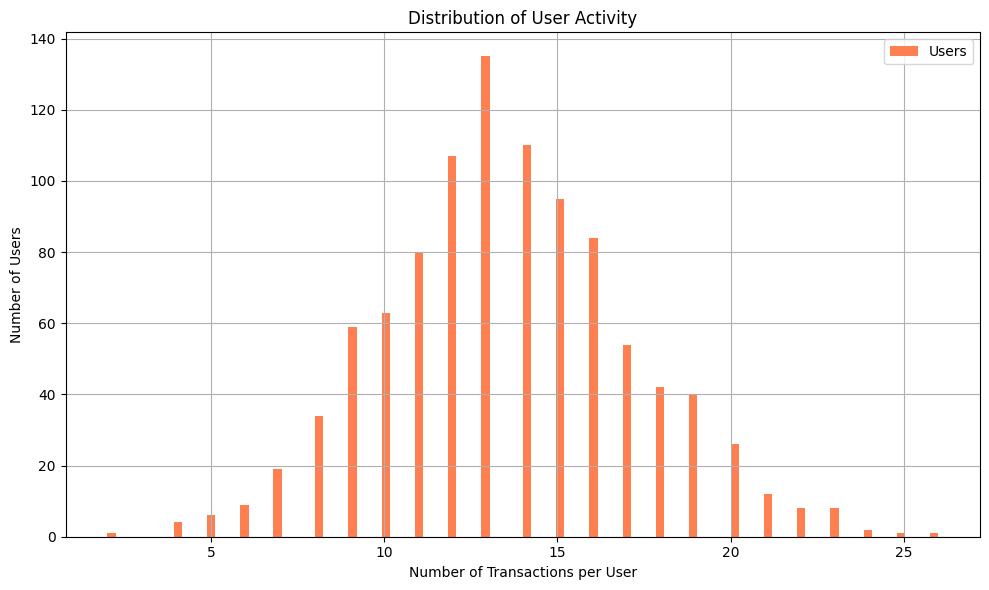

In [240]:
transactions_per_user = df['customer_id'].value_counts()

print("mean:",transactions_per_user.mean())
print("variance:",transactions_per_user.var())
plt.figure(figsize=(10, 6))
transactions_per_user.hist(bins=100, color='coral', label='Users')
plt.title('Distribution of User Activity')
plt.xlabel('Number of Transactions per User')
plt.ylabel('Number of Users')
plt.legend(loc='upper right') 
plt.grid(True)
plt.tight_layout()
plt.show()



According to the chart, the number of users remains relatively constant from 12:00 AM to 8:00 AM. Between 8:00 AM and 5:00 PM, there is a gradual increase, followed by a sharp rise from 5:00 PM to 6:00 PM. After 6:00 PM, the number of users begins to decline steadily, continuing until midnight.

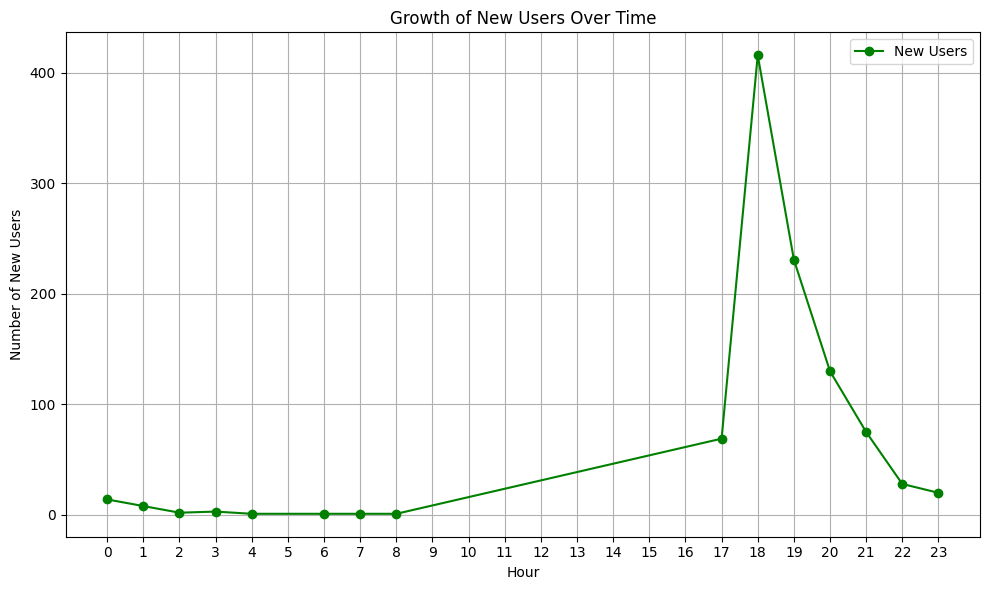

In [241]:
first_tx_per_user = df.groupby('customer_id')['timestamp'].min()

new_users_per_day = first_tx_per_user.groupby(first_tx_per_user.dt.hour).count()

plt.figure(figsize=(10, 6))
new_users_per_day.plot(kind='line', marker='o', color='green', label='New Users')
plt.title('Growth of New Users Over Time')
plt.xlabel('Hour')
plt.xticks(range(0, 24))
plt.ylabel('Number of New Users')
plt.legend(loc='upper right') 
plt.grid(True)
plt.tight_layout()
plt.show()

